# Randomized Kaczmarz algorithm assuming sparse system --- Sequential solver

In [1]:
import os, math, time
import numpy as np
import numpy.matlib
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import h5py
plt.style.use('default')

from harmonic_helper import *

In [2]:
fname = "3D_face_k_60.mat"

v, D_mat = HarmIO.read_hdf5(fname)
D = D_mat.T
V = v.T

sampled_rows = int(10000)
_ip = np.random.permutation(len(D[:,1]))
_idel = _ip[:sampled_rows]
D0 = D[_idel,:]
V0 = V[_idel,:]

_m, _n = D.shape
_m2, _n2 = D0.shape
print("System size is {} rows and {} columns for {} degrees".format(_m, _n, int(np.sqrt(_n)-1)))
print("The sparse system size is {} rows and {} columns for {} degrees".format(_m2, _n2, int(np.sqrt(_n2)-1)))
if _m2 < _n2:
    print("The sparse system is underdetermined.")
elif _m2 > _n2:
    print("The sparse system is overdetermined.")
else:
    print("The sparse system is determined.")

System size is 21238 rows and 3844 columns for 61 degrees
The sparse system size is 10000 rows and 3844 columns for 61 degrees
The sparse system is overdetermined.



Solver's time: 0.9524978558222453 min


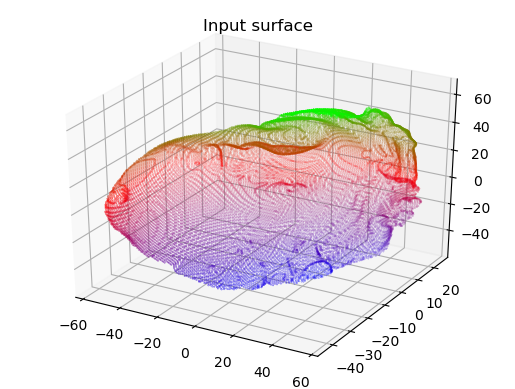

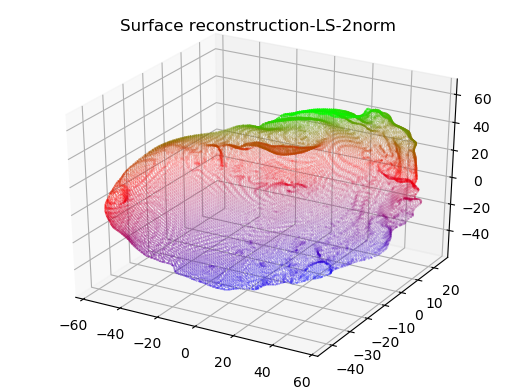

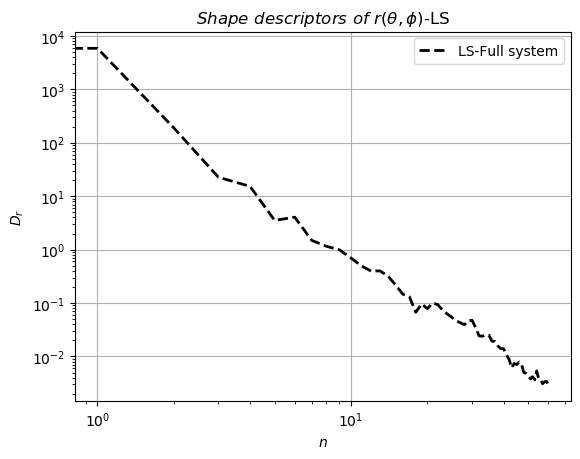

In [3]:
# The fastest parallel Least-squares solver (uses all the cores!)
coefs_LS = L2Solvers.solve_2_norm(D, V)

ax = plt.axes(projection='3d')
ax.scatter3D(V[:, 1], V[:, 2], V[:, 0], c=V[:, 0], s=0.1, cmap='brg');
plt.title("Input surface")
plt.show()

V1 = np.real(D @ coefs_LS)
ax = plt.axes(projection='3d')
ax.scatter3D(V1[:, 1], V1[:, 2], V1[:, 0], c=V1[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-LS-2norm")
plt.show()

Dx_LS, Dy_LS, Dz_LS = shape_descriptors(coefs_LS)
Dr_LS = Dx_LS + Dy_LS + Dz_LS
plt.figure()
plt.loglog(np.arange(len(Dr_LS)), Dr_LS, '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [4]:
max_iter = 16
relax = 0.3
support_size = 500

t1 = time.time()
x_RK_solver = Kaczmarz_solver(D0, V0[:, 0], x0=[], iterations = max_iter, relaxation = relax)
y_RK_solver = Kaczmarz_solver(D0, V0[:, 1], x0=[], iterations = max_iter, relaxation = relax)
z_RK_solver = Kaczmarz_solver(D0, V0[:, 2], x0=[], iterations = max_iter, relaxation = relax)

coef_x_kz = x_RK_solver.solve_Kaczmarz_sparse(support_size)
coef_y_kz = y_RK_solver.solve_Kaczmarz_sparse(support_size)
coef_z_kz = z_RK_solver.solve_Kaczmarz_sparse(support_size)
coefs_RK = np.array([coef_x_kz, coef_y_kz, coef_z_kz]).T

print("Overall processing time is {} min".format((time.time()-t1)/60))


Solver's time: 45.19323492050171 sec

Solver's time: 45.34144711494446 sec

Solver's time: 44.26547813415527 sec
Overall processing time is 2.265741165479024 min


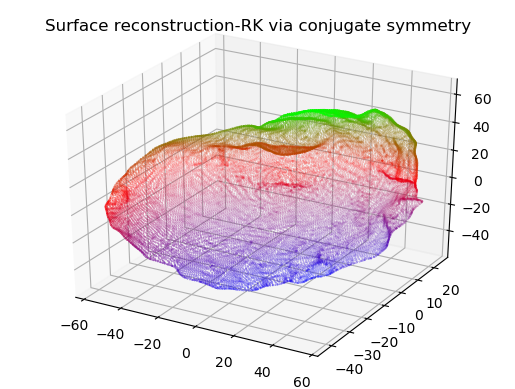

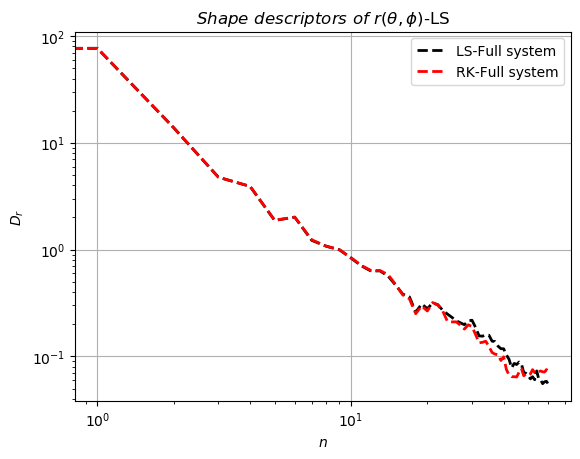

In [5]:
V2 = np.real(D @ coefs_RK)
ax = plt.axes(projection='3d')
ax.scatter3D(V2[:, 1], V2[:, 2], V2[:, 0], c=V2[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK via conjugate symmetry")
plt.show()

Dx_RK, Dy_RK, Dz_RK = shape_descriptors(coefs_RK)
Dr_RK = Dx_RK + Dy_RK + Dz_RK

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=2, markersize=10, label='RK-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

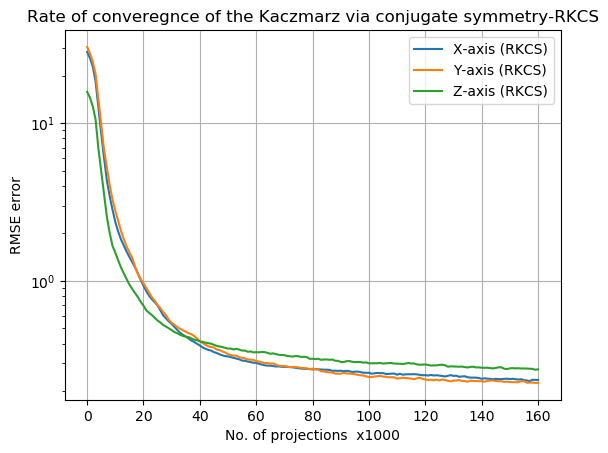

In [7]:
rec_steps = 1000

rec_error_x = x_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_y = y_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_z = z_RK_solver.reconstruct_history(rec_steps = rec_steps)

plt.figure()
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")
plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

In [8]:
HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_SRK.harmIO",
                        {"Dr_RK": Dr_RK, "coefs_RK": coefs_RK, "rec_error_x":rec_error_x, "rec_error_y":rec_error_y, "rec_error_z":rec_error_z})

In [9]:
HarmIO.export_mat("./postprocessing/"+"rec_"+fname[:-4]+"_SRK.mat", {"qm_k": coefs_RK})